<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/orthogonality_informativeness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation

In [ ]:
import numpy as np

In [ ]:
def simulate_correlation(dist, degree=20, n_samples=10000):
    samples = dist.rvs(size=n_samples)
    mapped = 2 * dist.cdf(samples) - 1
    vander = np.polynomial.legendre.legvander(mapped, deg=degree)
    return np.corrcoef(vander.T)

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


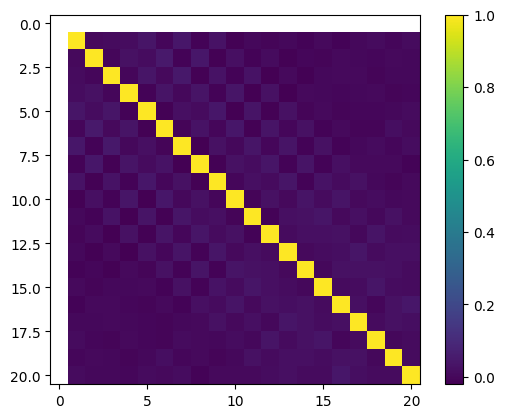

In [ ]:
plt.imshow(simulate_correlation(scipy.stats.norm(0, 1)))
plt.colorbar()
plt.show()

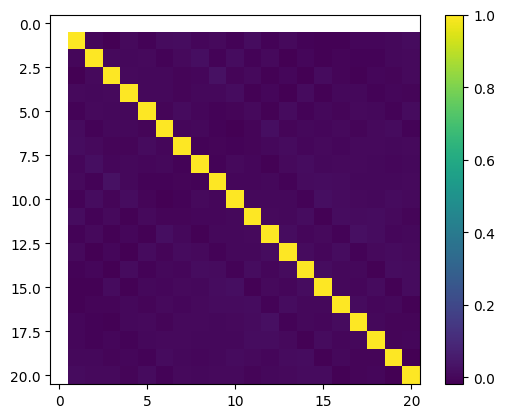

In [ ]:
plt.imshow(simulate_correlation(scipy.stats.norm(-5, 10)))
plt.colorbar()
plt.show()

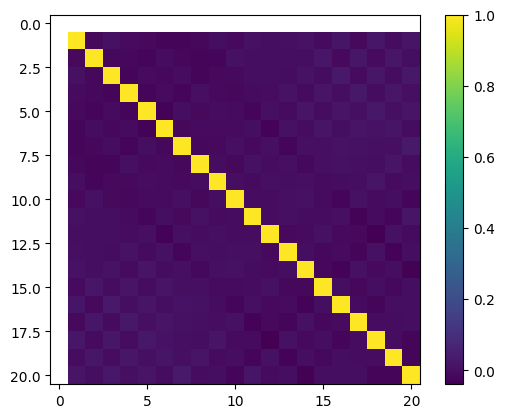

In [ ]:
plt.imshow(simulate_correlation(scipy.stats.gamma(8, 2)))
plt.colorbar()
plt.show()

# SKLearn pipeline

## Define pipeline

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils import check_array

class LegendreScalarPolynomialFeatures(TransformerMixin, BaseEstimator):
    def __init__(self, degree=2, include_bias=False):
        self.degree = degree
        self.include_bias = include_bias

    def fit(self, X, y=None):
        # There is nothing to learn
		# Legendre polynomials do not depend on the training data.
        return self

    def __sklearn_is_fitted__(self):
        # See above - it's always "fitted" by definition
        return True

    def transform(self, X, y=None):
        # Make sure X is of the right type and shape
        X = check_array(X, accept_sparse=False, ensure_all_finite=True)

        # create a Vandermonde matrix for each feature, and create a 3D array
        # of shape
        vander = np.polynomial.legendre.legvander(X, self.degree)
        if not self.include_bias:
            # discard the column of ones for each feature
            vander = vander[..., 1:]

        # reshape to concatenate the Vandermonde matrices horizontally
        n_rows = X.shape[0]
        result = vander.reshape(n_rows, -1)
        return result

In [ ]:
from sklearn.preprocessing import QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline

def ortho_features_pipeline(degree=8):
    return Pipeline([
        ('quantile-transformer', QuantileTransformer(n_quantiles=10000)),
        ('post-mapper', FunctionTransformer(lambda x: 2*x - 1)),
        ('polyfeats', LegendreScalarPolynomialFeatures(degree=degree)),
    ])

In [ ]:
# two columns - Normal and Gamma
sim_data = np.concatenate([
    scipy.stats.norm(-5, 3).rvs(size=(1000, 1)),
    scipy.stats.gamma(8, 2).rvs(size=(1000, 1)),
], axis=1)

# features
features = ortho_features_pipeline().fit_transform(sim_data)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (1000). n_quantiles is set to n_samples.
  warnings.warn(


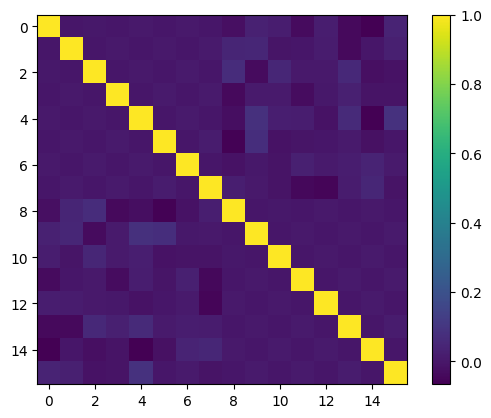

In [ ]:
coef_mat = np.corrcoef(features.T)
plt.imshow(coef_mat)
plt.colorbar()
plt.show()

## Load and pre-process data

In [ ]:
import pandas as pd

train_df = pd.read_csv("sample_data/california_housing_train.csv")
test_df = pd.read_csv("sample_data/california_housing_test.csv")
train_df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0


In [ ]:
X_train = train_df.drop("median_house_value", axis=1)
y_train = train_df["median_house_value"]

X_test = test_df.drop("median_house_value", axis=1)
y_test = test_df["median_house_value"]

In [ ]:
skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
X_train.loc[:, skewed_columns] = X_train[skewed_columns].apply(np.log)
X_test.loc[:, skewed_columns] = X_test[skewed_columns].apply(np.log)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

pipeline = Pipeline([
    ('ortho-features', ortho_features_pipeline()),
    ('lin-reg', LinearRegression()),
])
pipeline.fit(X_train, y_train)
root_mean_squared_error(y_test, pipeline.predict(X_test))

62672.703496184964

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def minmax_legendre_features(degree=8):
    return Pipeline([
        ('scaler', MinMaxScaler(feature_range=(-1, 1), clip=True)),
        ('polyfeats', LegendreScalarPolynomialFeatures(degree=degree)),
    ])

pipeline = Pipeline([
    ('minmax-legendre', minmax_legendre_features()),
    ('lin-reg', LinearRegression()),
])
pipeline.fit(X_train, y_train)
root_mean_squared_error(y_test, pipeline.predict(X_test))

63426.15965332127

In [ ]:
for deg in range(1, 22, 2):
    pipeline = Pipeline([
        ('minmax-legendre', minmax_legendre_features(degree=deg)),
        ('lin-reg', LinearRegression()),
    ])
    pipeline.fit(X_train, y_train)
    minmax_rmse = root_mean_squared_error(y_test, pipeline.predict(X_test))

    pipeline = Pipeline([
        ('ortho-features', ortho_features_pipeline(degree=deg)),
        ('lin-reg', LinearRegression()),
    ])
    pipeline.fit(X_train, y_train)
    ortho_rmse = root_mean_squared_error(y_test, pipeline.predict(X_test))

    print(f'Degree = {deg}, minmax_rmse = {minmax_rmse:.2f}, ortho_rmse = {ortho_rmse:.2f}')

Degree = 1, minmax_rmse = 67775.24, ortho_rmse = 74588.32
Degree = 3, minmax_rmse = 65137.16, ortho_rmse = 67551.46
Degree = 5, minmax_rmse = 64054.74, ortho_rmse = 65010.42
Degree = 7, minmax_rmse = 63523.41, ortho_rmse = 63297.67
Degree = 9, minmax_rmse = 63440.02, ortho_rmse = 61606.44
Degree = 11, minmax_rmse = 63305.14, ortho_rmse = 61438.60
Degree = 13, minmax_rmse = 65575.86, ortho_rmse = 61237.12
Degree = 15, minmax_rmse = 175047.47, ortho_rmse = 60611.78
Degree = 17, minmax_rmse = 175270.39, ortho_rmse = 60680.52
Degree = 19, minmax_rmse = 781416.93, ortho_rmse = 60111.46


In [ ]:
from sklearn.linear_model import RidgeCV

for deg in range(1, 22, 2):
    pipeline = Pipeline([
        ('minmax-legendre', minmax_legendre_features(degree=deg)),
        ('lin-reg', RidgeCV()),
    ])
    pipeline.fit(X_train, y_train)
    minmax_rmse = root_mean_squared_error(y_test, pipeline.predict(X_test))

    pipeline = Pipeline([
        ('ortho-features', ortho_features_pipeline(degree=deg)),
        ('lin-reg', RidgeCV()),
    ])
    pipeline.fit(X_train, y_train)
    ortho_rmse = root_mean_squared_error(y_test, pipeline.predict(X_test))

    print(f'Degree = {deg}, minmax_rmse = {minmax_rmse:.2f}, ortho_rmse = {ortho_rmse:.2f}')

Degree = 1, minmax_rmse = 67771.06, ortho_rmse = 74482.30
Degree = 3, minmax_rmse = 65121.63, ortho_rmse = 67485.67
Degree = 5, minmax_rmse = 64077.37, ortho_rmse = 64971.80
Degree = 7, minmax_rmse = 63541.46, ortho_rmse = 63380.61
Degree = 9, minmax_rmse = 63394.64, ortho_rmse = 61650.67
Degree = 11, minmax_rmse = 62889.19, ortho_rmse = 61386.24
Degree = 13, minmax_rmse = 62305.72, ortho_rmse = 61192.17
Degree = 15, minmax_rmse = 62276.36, ortho_rmse = 60649.21
Degree = 17, minmax_rmse = 62045.29, ortho_rmse = 60677.81
Degree = 19, minmax_rmse = 61883.94, ortho_rmse = 60165.78
Degree = 21, minmax_rmse = 61802.18, ortho_rmse = 59526.32
